In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os

In [2]:
path = 'E:\\Data_Science\\OpenClassRoom\\Projet 5\\archive'
cust_df=pd.read_csv(path + '\\olist_customers_dataset.csv')
geo_df=pd.read_csv(path +'\\olist_geolocation_dataset.csv')
ord_it_df=pd.read_csv(path + '\\olist_order_items_dataset.csv')
ord_pay_df=pd.read_csv(path + '\\olist_order_payments_dataset.csv')
ord_rev_df=pd.read_csv(path + '\\olist_order_reviews_dataset.csv')
ord_df=pd.read_csv(path + '\\olist_orders_dataset.csv')
prod_df=pd.read_csv(path + '\\olist_products_dataset.csv')
sell_df=pd.read_csv(path + '\\olist_sellers_dataset.csv')

In [3]:
dfs = {0:cust_df,1:geo_df,2:ord_it_df,3:ord_pay_df,4:ord_rev_df,5:ord_df,6:prod_df,7:sell_df}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

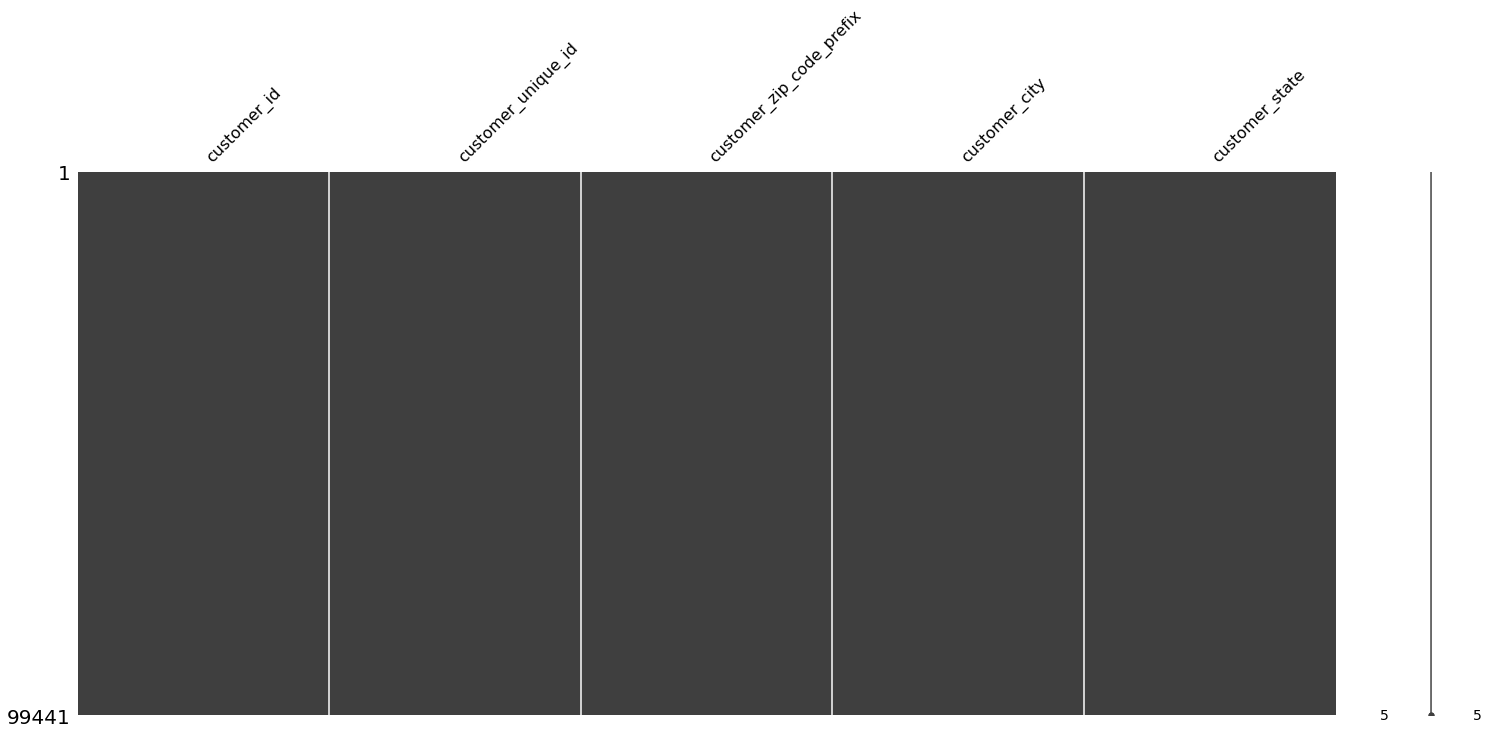

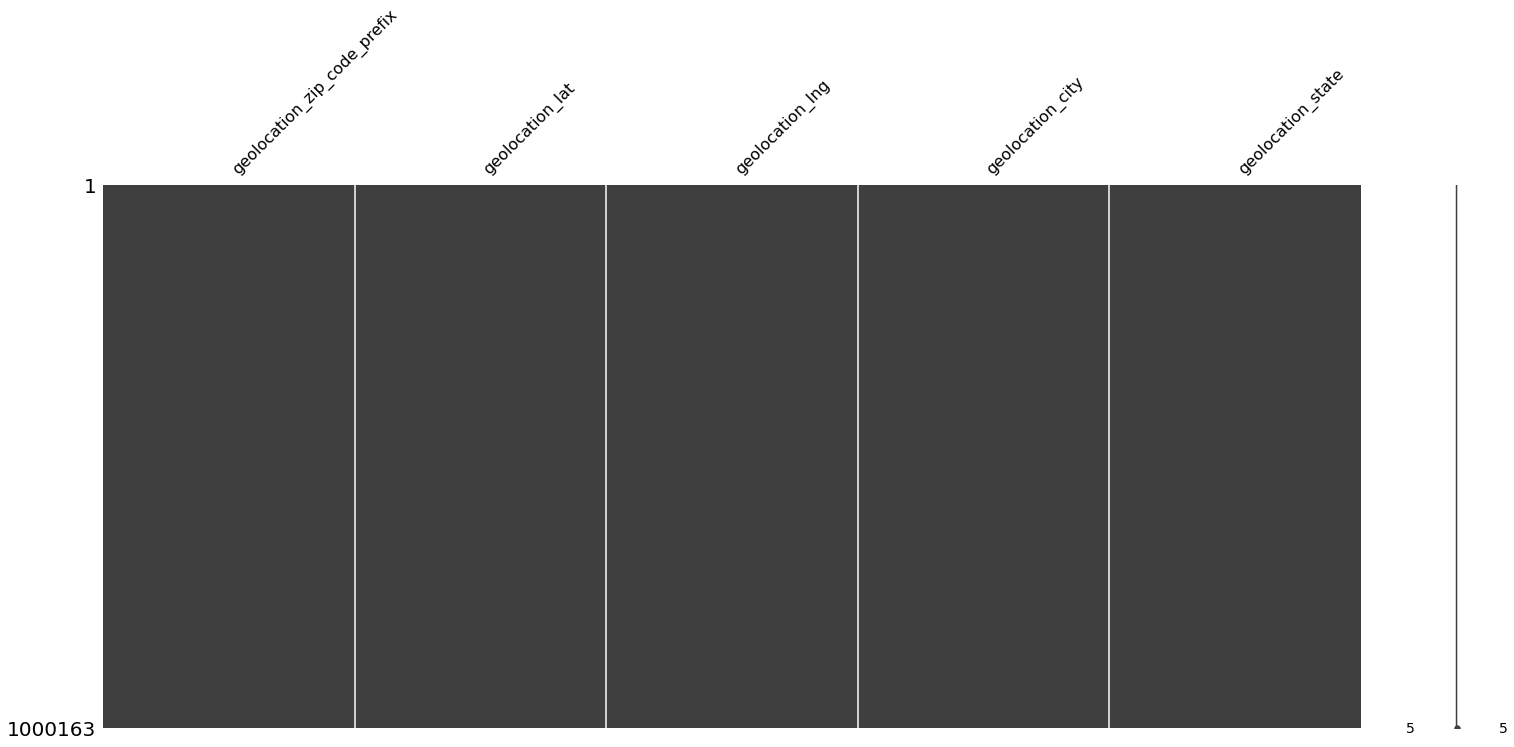

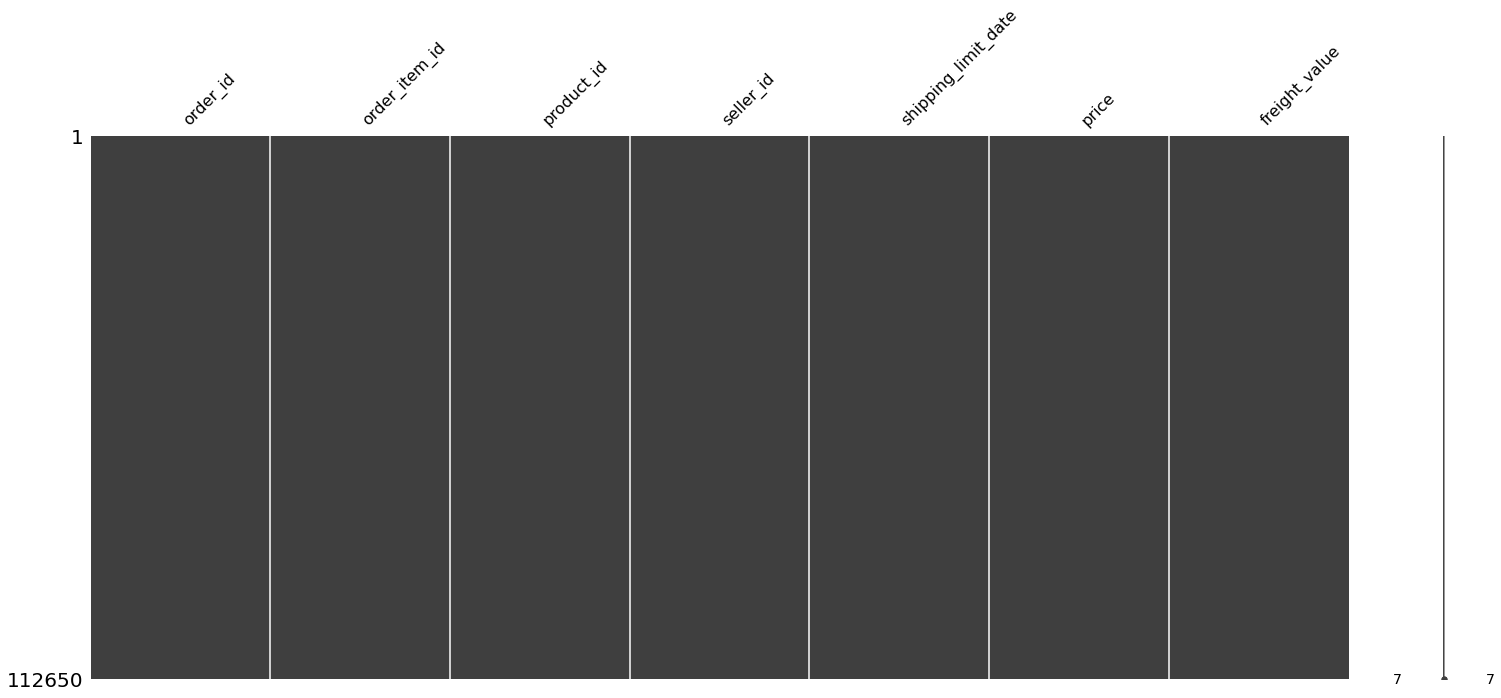

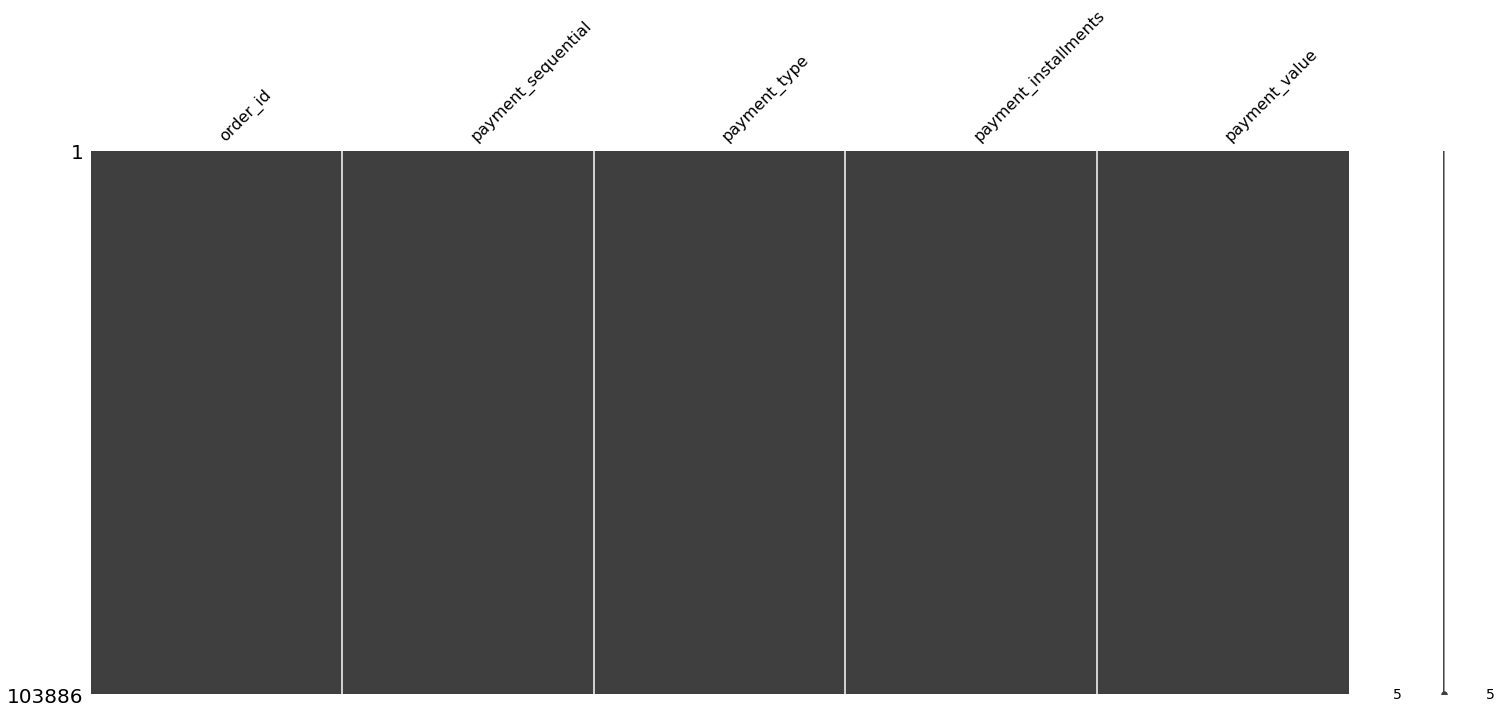

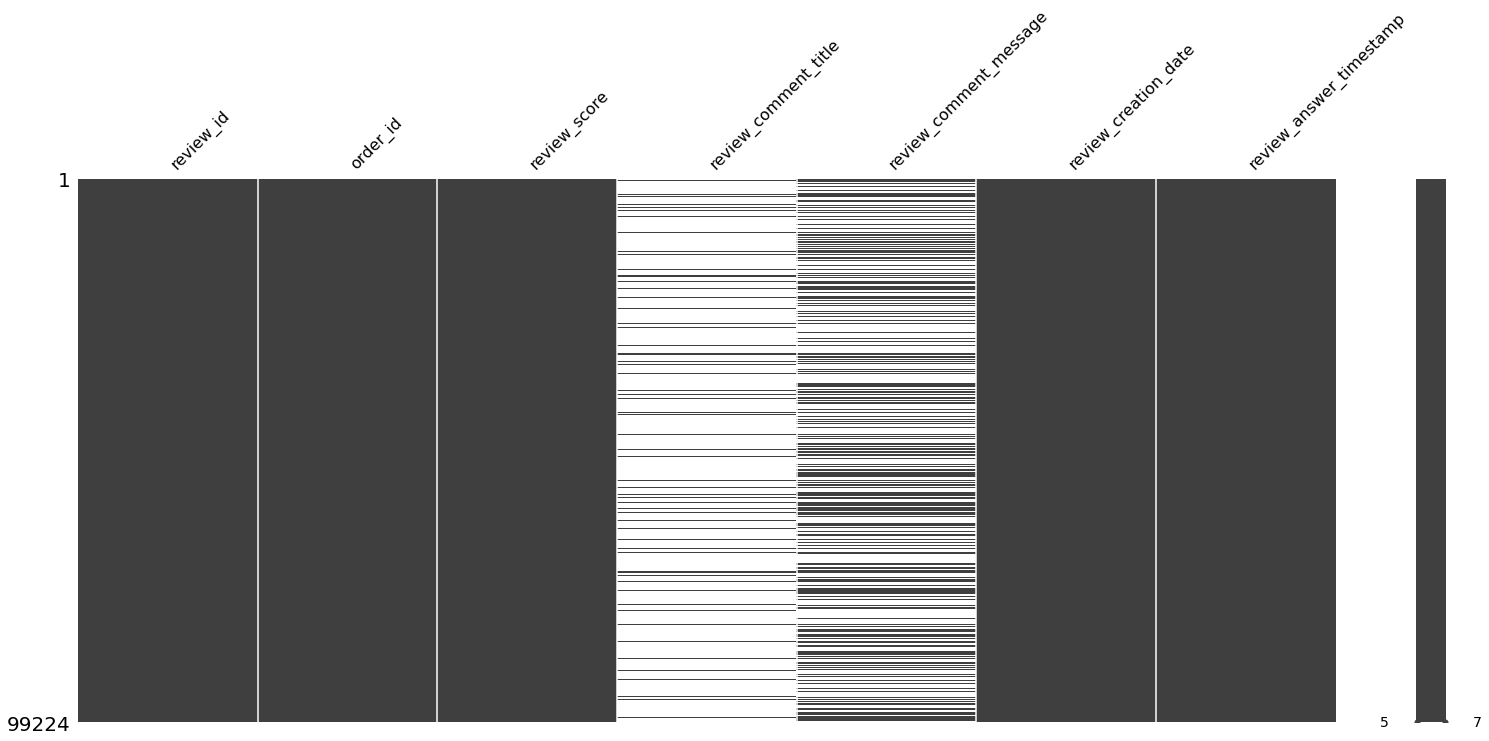

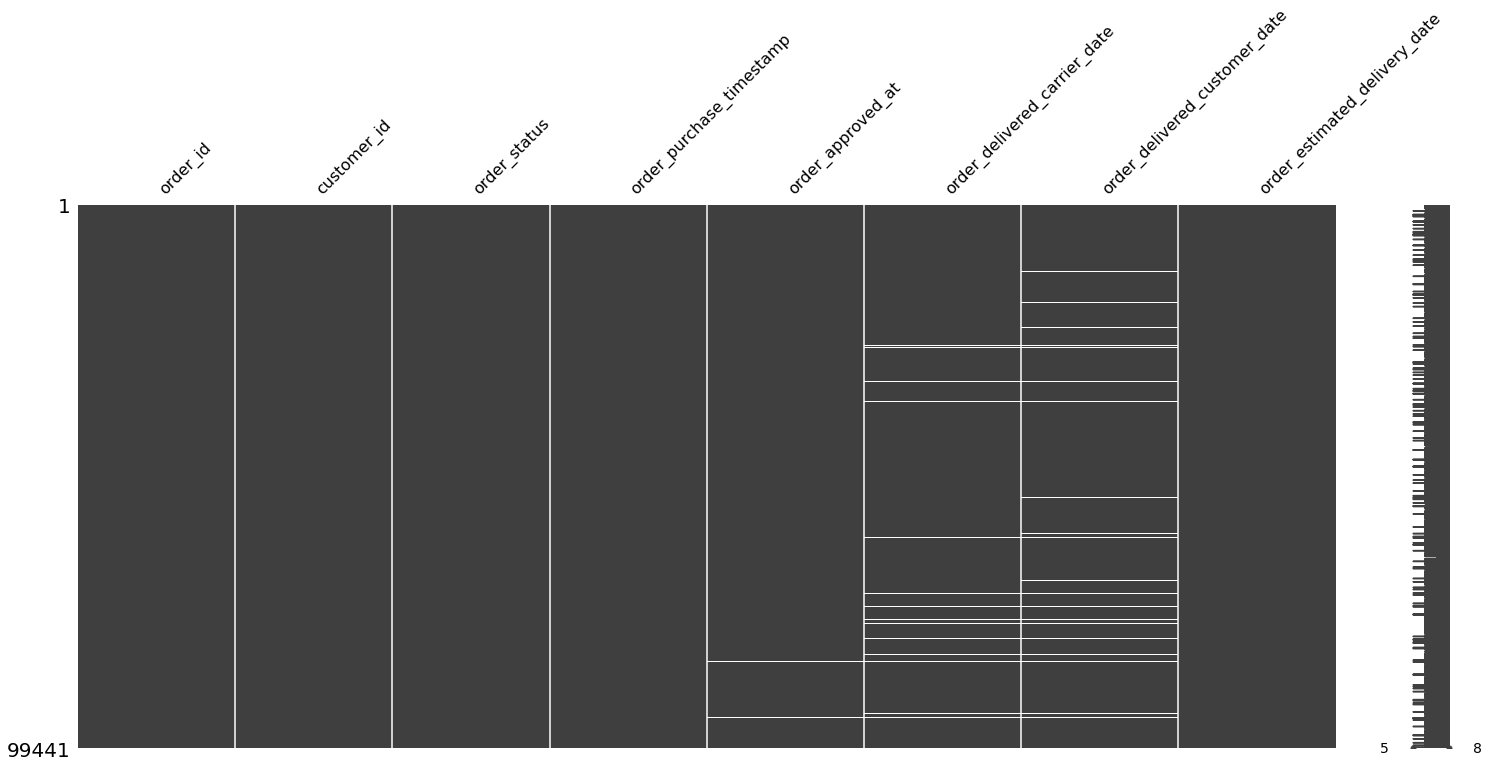

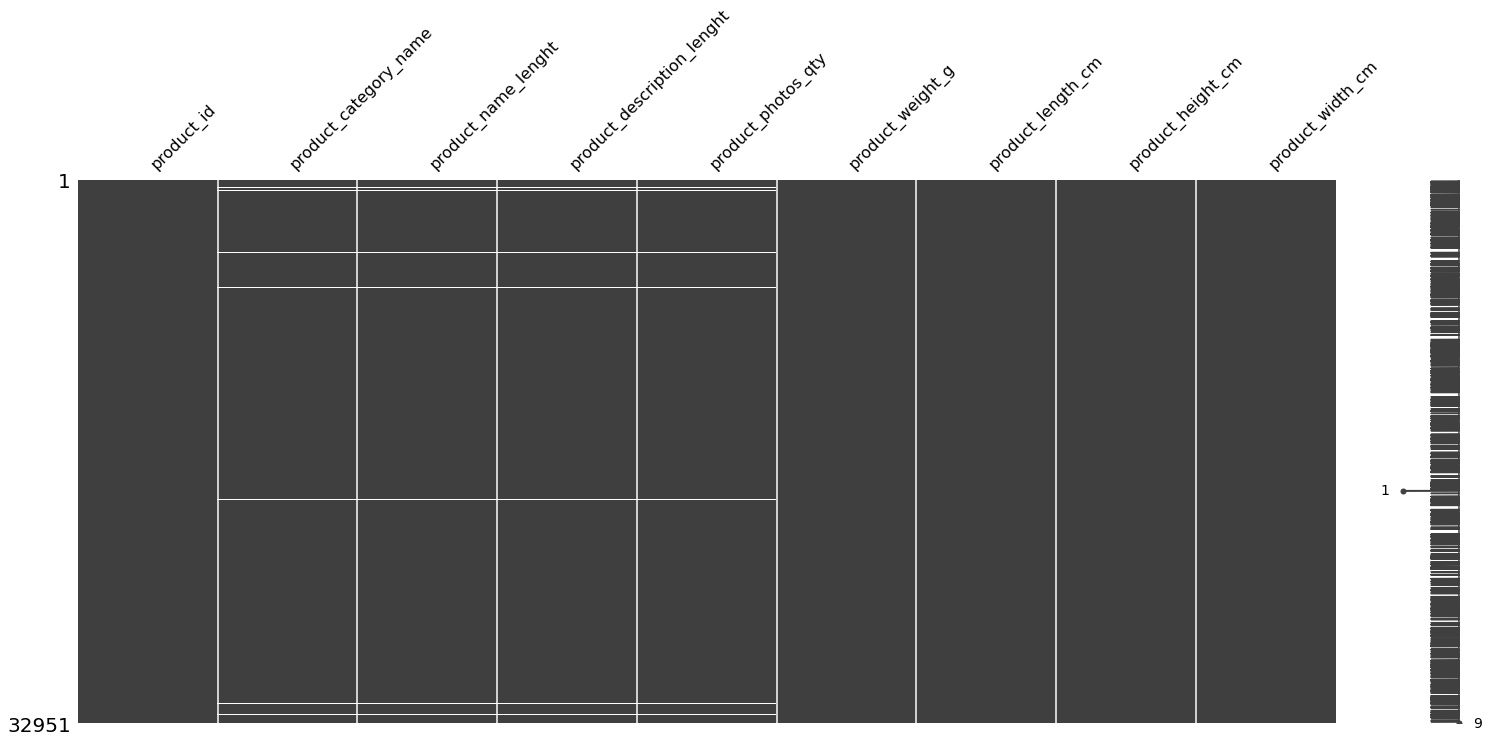

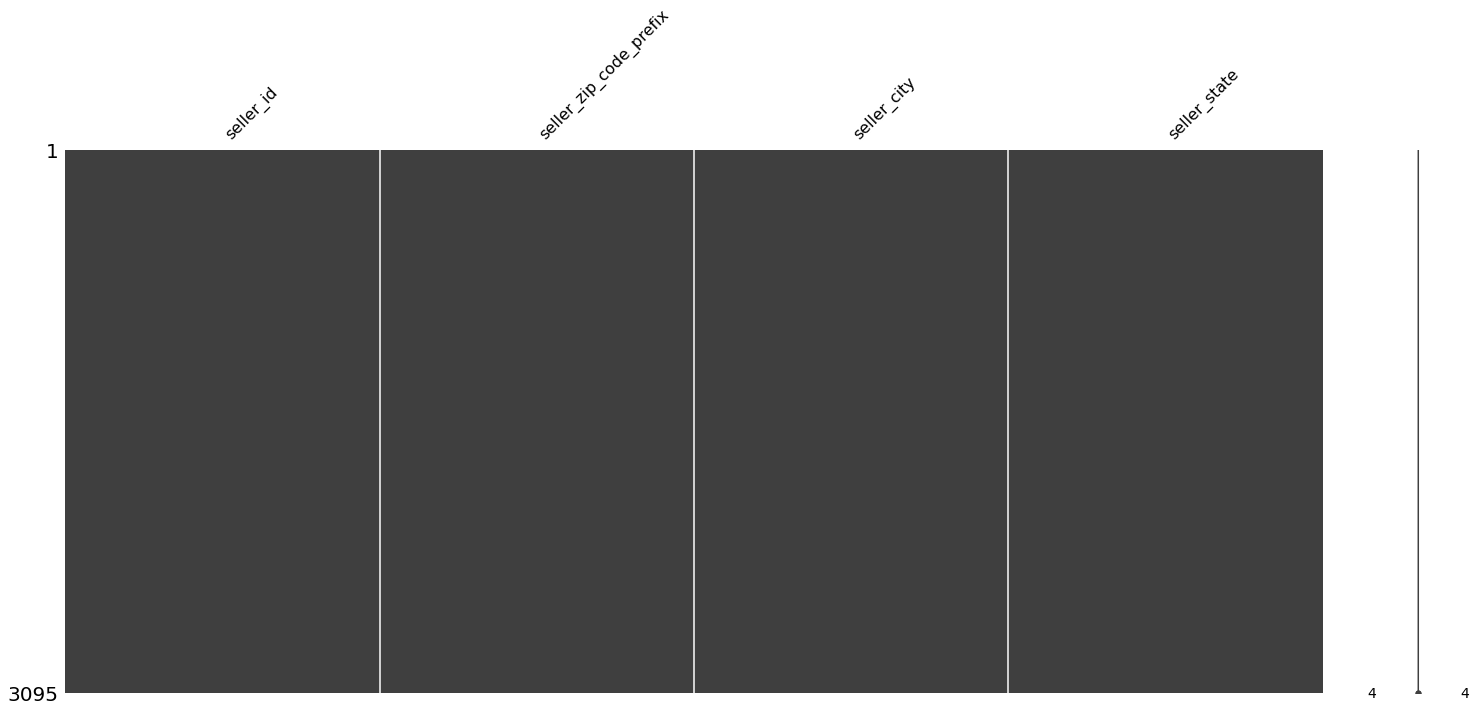

In [4]:
for i in dfs:
    print(dfs[i].info())
    msno.matrix(dfs[i])

In [5]:
#get the customers that ordered more than once
multi_cust_df = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 1]

#get their customer_id
multi_custom = multi_cust_df[['customer_id','customer_unique_id']]
multi_id = multi_custom['customer_id']
multi_uni_id = multi_custom['customer_unique_id']
#get their order_id
multi_order_df = dfs[5][dfs[5]['customer_id'].isin(multi_id)]
multi_order_id = multi_order_df['order_id']

multi_pay_df = dfs[3][dfs[3]['order_id'].isin(multi_order_id)]
#get their review score
multi_rev_df = dfs[4][dfs[4]['order_id'].isin(multi_order_id)]

#get the category of each order
multi_prod_df =  dfs[2][dfs[2]['order_id'].isin(multi_order_id)]
multi_prod_id = multi_prod_df['product_id']
multi_cat_df = dfs[6][dfs[6]['product_id'].isin(multi_prod_id)].set_index('product_id')

cat_ser = multi_cat_df['product_category_name']
multi_prod_df = multi_prod_df.join(cat_ser, on = 'product_id')
multi_prod_df = multi_prod_df.dropna(subset = 'product_category_name') #74 product don't have a category name


In [6]:
multi_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7469 entries, 1 to 112630
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               7469 non-null   object 
 1   order_item_id          7469 non-null   int64  
 2   product_id             7469 non-null   object 
 3   seller_id              7469 non-null   object 
 4   shipping_limit_date    7469 non-null   object 
 5   price                  7469 non-null   float64
 6   freight_value          7469 non-null   float64
 7   product_category_name  7469 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 525.2+ KB


In [7]:
def cat_name(x):
    temp = set()
    for i in x:
        if i not in temp:
            temp.add(i)
    temp = str(temp)
    return temp

In [8]:
multi_cat_df['product_category_name'].unique().shape

(71,)

In [9]:
x = dfs[0]['customer_id'].unique().shape[0]
y = dfs[0]['customer_unique_id'].unique().shape[0]
print(x,y, 1-(y/x))

99441 96096 0.033638036624732304


In [10]:
import time
import datetime

def days(x):
    td = time.time()
    t = time.mktime(datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S").timetuple())
    d = int((td - t)/86400)
    return d

In [11]:
##build the working df of each order
#take the customer id
df = pd.DataFrame(multi_custom)
df = df.set_index('customer_id')
df = df.join(multi_order_df[['customer_id','order_id', 'order_purchase_timestamp']].set_index('customer_id'))
#take the value of each order
temp = pd.DataFrame()
temp['order_total'] = multi_pay_df.groupby('order_id').payment_value.sum() #some order have voucher
df = df.join(temp, on = 'order_id')
#calculate the days since order of each order
df['days_since_order'] = df['order_purchase_timestamp'].apply(days)
#take the review score for each order
temp = pd.DataFrame(index = multi_rev_df.index)
temp['review_days'] = multi_rev_df['review_creation_date'].apply(days)
temp = temp.join(multi_rev_df[['order_id', 'review_score']])
agg_fun = {'review_days' : ['min'], 'review_score' : ['mean']}
temp = temp.groupby('order_id').agg(agg_fun)
df = df.join(temp, on = 'order_id', how='right')
df = df.drop(df.columns[5], axis=1 ) 
df = df.rename(columns = {df.columns[5] : 'review_score'})

#take the product category of each order
temp = pd.DataFrame(multi_prod_df.groupby('order_id').product_category_name.agg(lambda x: tuple(x)))

def cat_name(x):  #some orders have mulitple items from the same category
    y = set()
    for i in x:
        if i not in y:
            y.add(i)
    y = str(y)
    return y

temp['product_category_name'] = temp.applymap(cat_name)
df = df.join(temp, on = 'order_id')
df =df.dropna(subset = 'product_category_name')
df =  df[df.groupby('customer_unique_id').customer_unique_id.transform('count') > 1]#some customer didn't review all their orders
print(df.info(),df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5929 entries, f6dd3ec061db4e3987629fe6b26e5cce to c5d108ecadaedf367e995520d36c9b1d
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        5929 non-null   object 
 1   order_id                  5929 non-null   object 
 2   order_purchase_timestamp  5929 non-null   object 
 3   order_total               5929 non-null   float64
 4   days_since_order          5929 non-null   int64  
 5   review_score              5929 non-null   float64
 6   product_category_name     5929 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 370.6+ KB
None                                                 customer_unique_id  \
customer_id                                                          
f6dd3ec061db4e3987629fe6b26e5cce  eb28e67c4c0b83846050ddfb8a35d051   
8085a9af46f619bc25966f151a362b0d  98758d88bf4b8eef1372ddee45d63178

E:\temp\ipykernel_37144\2430091187.py:18: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.join(temp, on = 'order_id', how='right')


In [12]:
temp = pd.crosstab(df['customer_unique_id'], df['product_category_name'], values = df['product_category_name'], aggfunc= 'count', margins = True).fillna(0)

if (temp.iloc[-1,:] == 0.0).any():
    print('any')


In [55]:
df['order_dis'] = pd.cut(df['order_total'],30, duplicates = 'drop')
temp = pd.crosstab(df['customer_unique_id'], df['order_dis'], values = df['order_dis'], aggfunc= 'count', margins = True)
temp = temp.dropna(axis = 1, how = 'any')
temp

order_dis,"(6.621, 176.186]","(176.186, 340.812]","(340.812, 505.438]","(505.438, 670.064]","(670.064, 834.69]","(834.69, 999.316]","(999.316, 1163.942]","(1163.942, 1328.568]","(1328.568, 1493.194]","(1493.194, 1657.82]","(1657.82, 1822.446]","(1822.446, 1987.072]","(1987.072, 2151.698]","(2480.95, 2645.576]","(4785.714, 4950.34]",All
customer_unique_id,,,,,,,,,,,,,,,,
004288347e5e88a27ded2bb23747066c,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
004b45ec5c64187465168251cd1c9c2f,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
0058f300f57d7b93c477a131a59b36c3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
00a39521eb40f7012db50455bf083460,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
00cc12a6d8b578b8ebd21ea4e2ae8b27,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff44401d0d8f5b9c54a47374eb48c1b8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ff8892f7c26aa0446da53d01b18df463,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ff922bdd6bafcdf99cb90d7f39cea5b3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [56]:
#build the model df
md_df = pd.DataFrame(index = df['customer_unique_id'].unique())

#feature0  = number of order
md_df['n_order'] = df.groupby('customer_unique_id').order_id.count()

#feature1  = total value of orders
#md_df['payment_total'] = df.groupby('customer_unique_id').order_total.agg('sum')

#feature2-3  = mean and std of orders
md_df['payment_mean'] = df.groupby('customer_unique_id').order_total.agg('mean')
md_df['payment_std'] = df.groupby('customer_unique_id').order_total.agg('std')

#feature frequency4-10 of order on the distrib
df['order_dis'] = pd.cut(df['order_total'],30, duplicates = 'drop')
temp = pd.crosstab(df['customer_unique_id'], df['order_dis'], values = df['order_dis'], aggfunc= 'count', margins = True)
temp = temp.dropna(axis = 1, how = 'any') #drop empty buckets
for i in range(temp.shape[1]):
    temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)

temp = temp.drop(labels = 'All')
temp = temp.drop(labels = 'All', axis = 1)
md_df = md_df.join(temp)
print(md_df.info())
#feature frequency11-135 of category
temp = pd.crosstab(df['customer_unique_id'], df['product_category_name'], values = df['product_category_name'], aggfunc= 'count', margins = True).fillna(0)
for i in range(temp.shape[1]):
    temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)
temp = temp.drop(labels = 'All')
temp = temp.drop(labels = 'All', axis = 1)
md_df = md_df.join(temp)
print(md_df.info())
#feature136-137 review score mean and std
md_df['rev_mean'] = df.groupby('customer_unique_id').review_score.agg('mean')
md_df['rev_std'] = df.groupby('customer_unique_id').review_score.agg('std')
#feature138  = days since last order
md_df['days_since_last_order'] = df.groupby('customer_unique_id').days_since_order.agg('min')
#feature139 = "age" of the custumer
md_df['age'] = df.groupby('customer_unique_id').days_since_order.agg('max')


print(md_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2808 entries, eb28e67c4c0b83846050ddfb8a35d051 to acc4424c209233de519e034152f30304
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   n_order               2808 non-null   int64  
 1   payment_mean          2808 non-null   float64
 2   payment_std           2808 non-null   float64
 3   (6.621, 176.186]      2808 non-null   float64
 4   (176.186, 340.812]    2808 non-null   float64
 5   (340.812, 505.438]    2808 non-null   float64
 6   (505.438, 670.064]    2808 non-null   float64
 7   (670.064, 834.69]     2808 non-null   float64
 8   (834.69, 999.316]     2808 non-null   float64
 9   (999.316, 1163.942]   2808 non-null   float64
 10  (1163.942, 1328.568]  2808 non-null   float64
 11  (1328.568, 1493.194]  2808 non-null   float64
 12  (1493.194, 1657.82]   2808 non-null   float64
 13  (1657.82, 1822.446]   2808 non-null   float64
 14  (1822.446, 1987.07

<AxesSubplot:>

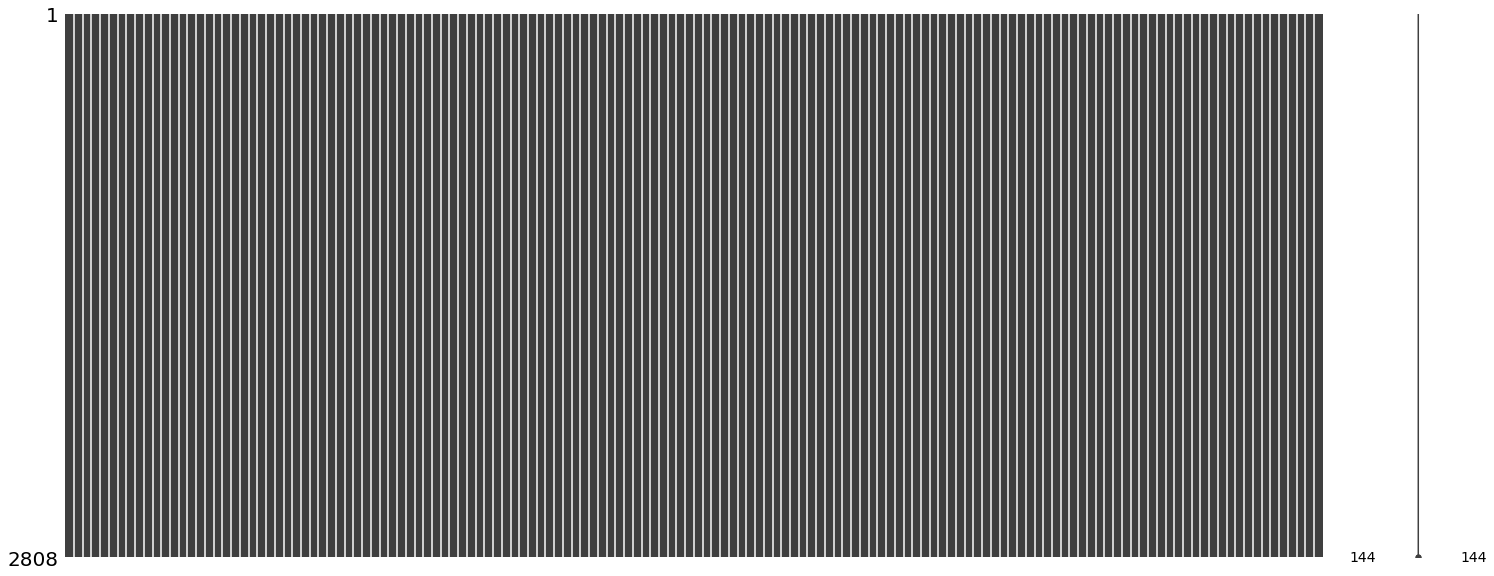

In [57]:
msno.matrix(md_df)

In [58]:
md_df.to_csv('md_df.csv', index = False)

## Dimention reduction

In [59]:
dim_df = pd.read_csv('md_df.csv')

x = dim_df.values
features = dim_df.columns

In [60]:
dim_df.isna().sum().sum()

0

In [61]:
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components = 2)
scaler = preprocessing.StandardScaler()
rscaler = preprocessing.RobustScaler()
mscaler = preprocessing.MinMaxScaler()

x_scale = rscaler.fit_transform(x)

pca.fit(x_scale)

PCA(n_components=2)

In [62]:
scree = (pca.explained_variance_ratio_*100).round(2).cumsum()
print(scree)

[13.61 24.  ]


In [63]:
pd.DataFrame(pca.components_, columns = features, index = ['F1', 'F2'])



,n_order,payment_mean,payment_std,"(6.621, 176.186]","(176.186, 340.812]","(340.812, 505.438]","(505.438, 670.064]","(670.064, 834.69]","(834.69, 999.316]","(999.316, 1163.942]",...,"{'utilidades_domesticas', 'bebes'}","{'utilidades_domesticas', 'cama_mesa_banho'}","{'utilidades_domesticas', 'esporte_lazer'}","{'utilidades_domesticas', 'market_place'}","{'utilidades_domesticas', 'moveis_decoracao'}",{'utilidades_domesticas'},rev_mean,rev_std,days_since_last_order,age
F1,0.000122,-0.001011,-0.000728,-0.000235,0.000491,0.005538,-0.003887,-0.005332,-0.001563,-0.001473,...,-0.000135,-0.000423,-0.000135,0.000605,0.000467,-0.020053,-0.001557,-0.000753,0.001391,0.000794
F2,0.000615,0.000186,-0.001980,-0.000727,0.001244,-0.006400,-0.010917,-0.002613,0.000455,-0.002568,...,-0.000115,-0.000950,-0.000151,0.000046,-0.000405,-0.047045,0.000715,-0.001299,0.001015,0.000730


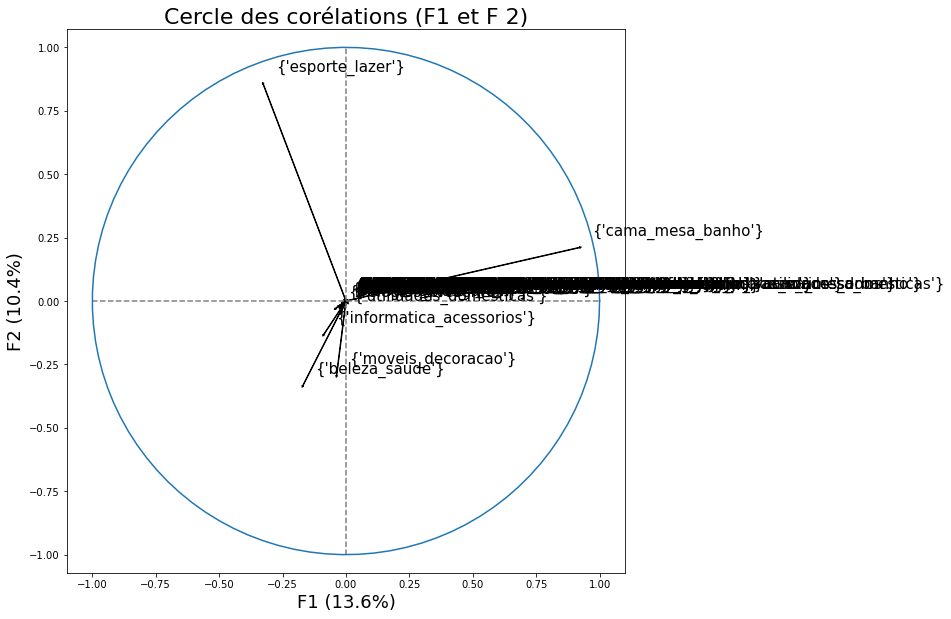

<Figure size 432x288 with 0 Axes>

In [64]:
x, y = 0,1 #define factorial space, (0,1) define the first factorial plane (F1, F2), (2,3) define the second (F3,F4) and so on(tuple)

fig, ax = plt.subplots(figsize = (10,10))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,0, #start the arrow at the origin
                    pca.components_[0,i], #coordinate for PC1
                    pca.components_[1,i], #coordinate for PC2
                    head_width = 0.007,
                    head_length = 0.007,
                    width=0.002,) #graphical aspect of the arrow
    plt.text(pca.components_[0,i] + 0.05,
                        pca.components_[1,i] + 0.05,
                        features[i], fontsize = 15) # plot the text near each arrow head
plt.plot([-1,1], [0,0], color = 'grey', ls='--')
plt.plot([0,0], [-1,1], color='grey', ls='--') #plot the lines (abscissa and ordonate)

plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)), fontsize = 18) #label the axis with the percentage of explained variance
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)),fontsize = 18)

plt.title('Cercle des corélations (F{} et F {})'.format(x+1, y+1), fontsize = 22)

an = np.linspace(0, 2 * np.pi, 100) #return an np.array of the coordinates (100) of a circle of circonference 1 (2*pi)
plt.plot(np.cos(an), np.sin(an)) #plot the circle
plt.axis('equal') #set equal scaling
plt.show()
plt.clf()

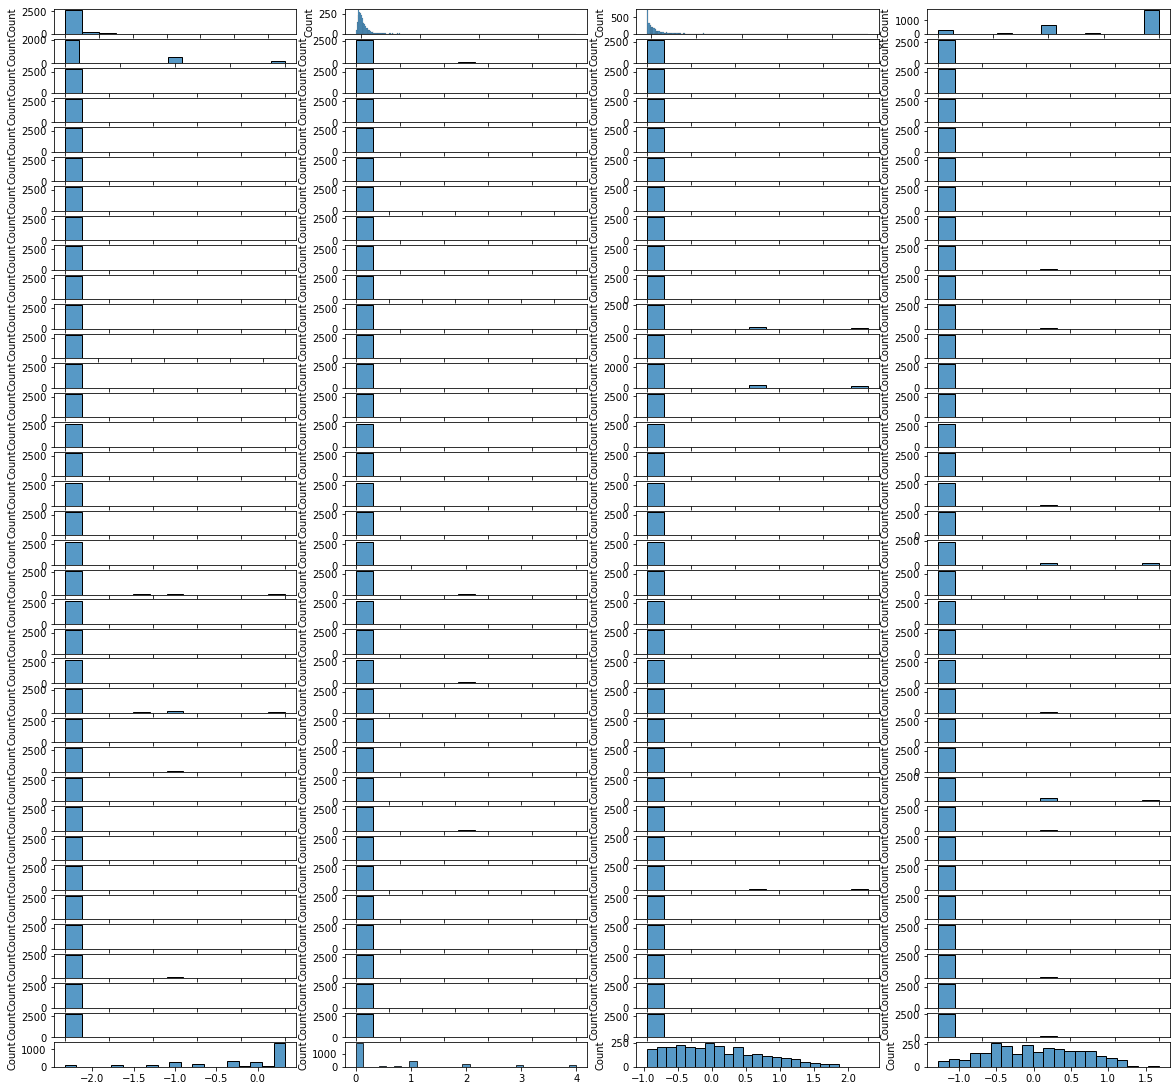

In [65]:
fig = plt.figure(figsize=(20,20))
for i in range(x_scale.shape[1]):
    ax = fig.add_subplot(int((x_scale.shape[1]/4)+1), 4, i+1)
    sns.histplot(x_scale[:,i], ax = ax)

plt.show()

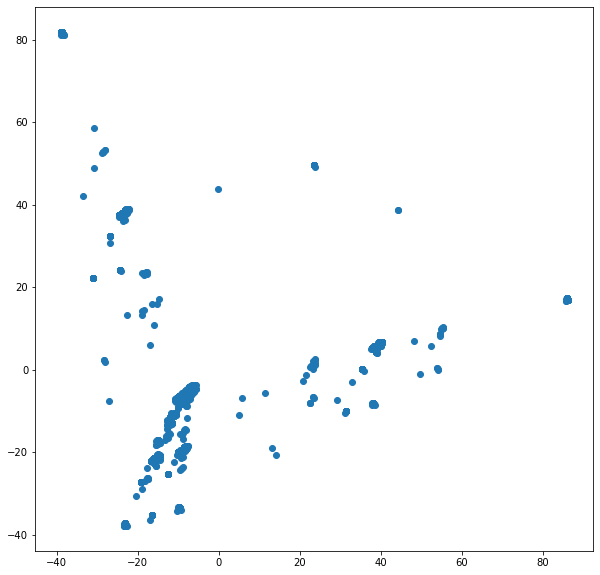

In [66]:
x_proj = pca.transform(x_scale)
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x_proj[:,0],x_proj[:,1])
plt.show()

In [101]:
from sklearn.manifold import Isomap
iso = Isomap()
from sklearn.manifold import MDS
mds = MDS()
from sklearn.manifold import TSNE
tsne = TSNE()

x_proj2 = mds.fit_transform(x_scale)
x_proj3 = tsne.fit_transform(x_scale)
x_proj4 = iso.fit_transform(x_scale)

E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
E:\Data_Science\Anaconda\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Data_Science\Anaconda\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity st

In [68]:
from sklearn import cluster, metrics

Text(0.55, 0.4, 'Best silhouette : 0.41, Optimal Clus : 45')

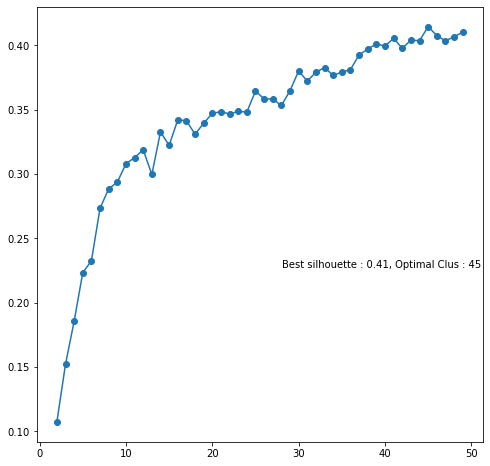

In [100]:
silhouette = []
for i in range(2,50):
    clus = cluster.KMeans(n_clusters = i)
    clus.fit(x_scale)
    sil  = metrics.silhouette_score(x_scale, clus.labels_)
    silhouette.append(sil)
max_sil = max(silhouette)
index = (silhouette.index(max_sil) +2)
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(range(2,50), silhouette, marker ='o')
ax.text(0.55,0.4,'Best silhouette : {:.2f}, Optimal Clus : {}'.format(max_sil, index), transform = ax.transAxes)

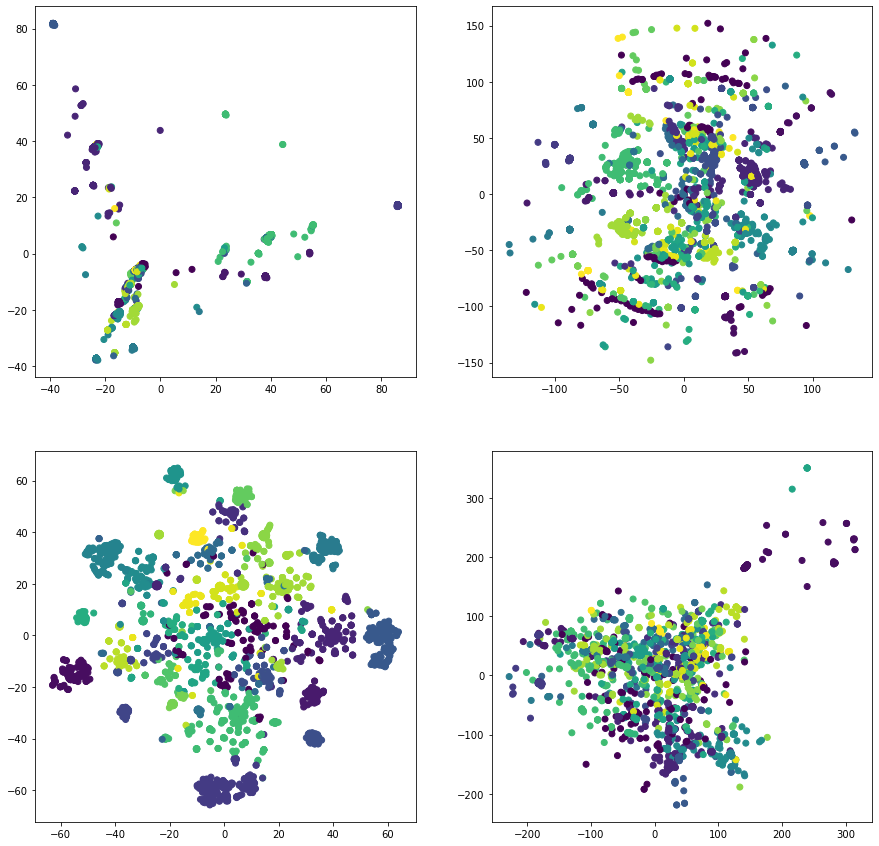

In [102]:
clus = cluster.KMeans(n_clusters = 30)
clus.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=clus.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=clus.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=clus.labels_)
ax[1,1].scatter(x_proj4[:,0], x_proj4[:,1], c=clus.labels_)
plt.show()

Text(0.55, 0.4, 'Best silhouette : 0.48, Optimal Eps : 4.5')

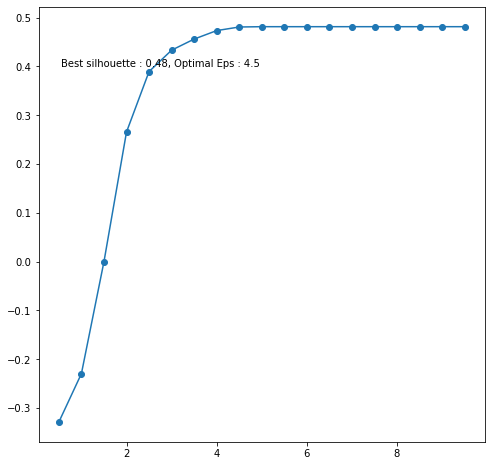

In [71]:
silhouette = []
eps_range = list(np.arange(0.5,10,0.5))
for i in eps_range:
    dbscan = cluster.DBSCAN(eps = i)
    dbscan.fit(x_scale)
    sil  = metrics.silhouette_score(x_scale, dbscan.labels_)
    silhouette.append(sil)
    
max_sil = max(silhouette)
index = (silhouette.index(max_sil))
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(np.arange(0.5,10,0.5), silhouette, marker ='o')
ax.text(0.55,0.4,'Best silhouette : {:.2f}, Optimal Eps : {}'.format(max_sil, round(index/2,2), transform = ax.transAxes))

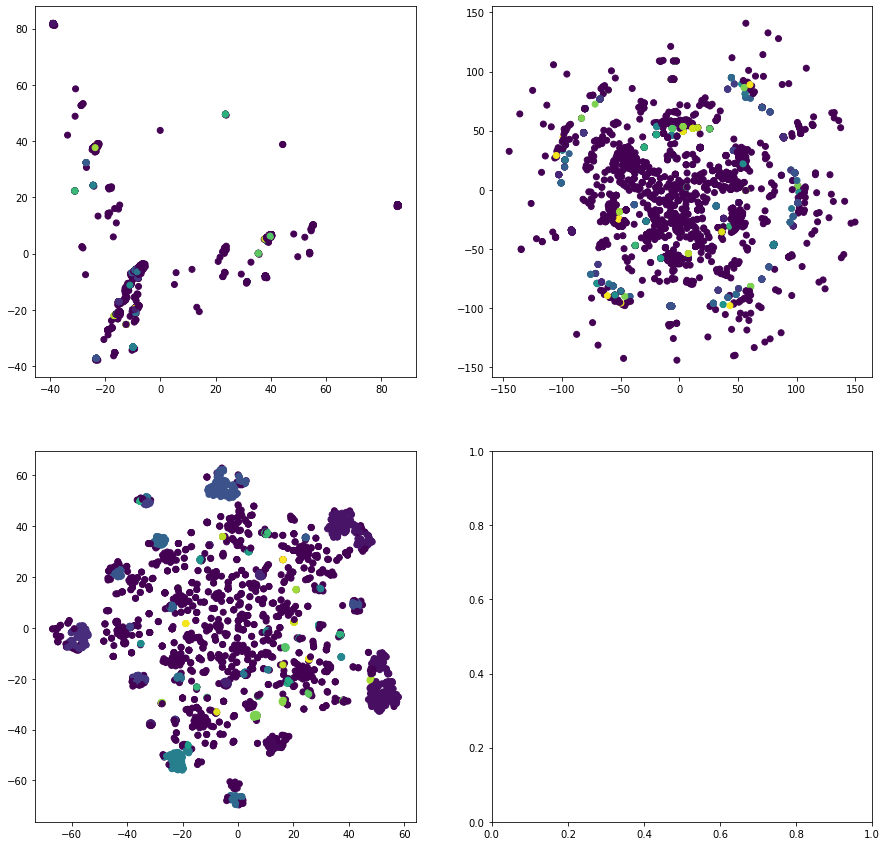

In [72]:


dbscan = cluster.DBSCAN(eps = 1.6)

dbscan.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=dbscan.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=dbscan.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=dbscan.labels_)

plt.show()

In [73]:
md_df['clus_label'] = clus.labels_
clus_sil = round(metrics.silhouette_score(x_scale, clus.labels_),2)
md_df['dbscan_label'] = dbscan.labels_
dbscan_sil = round(metrics.silhouette_score(x_scale, dbscan.labels_),2)
print('KMeans have found {} clusters with a silhouette score of : {}'.format(len(md_df['clus_label'].unique()), clus_sil))
print('BDscan have found {} clusters with a silhouette score of : {}'.format(len(md_df['dbscan_label'].unique()), dbscan_sil))

KMeans have found 30 clusters with a silhouette score of : 0.37
BDscan have found 57 clusters with a silhouette score of : 0.1


In [75]:
md_df.describe()

,n_order,payment_mean,payment_std,"(6.621, 176.186]","(176.186, 340.812]","(340.812, 505.438]","(505.438, 670.064]","(670.064, 834.69]","(834.69, 999.316]","(999.316, 1163.942]",...,"{'utilidades_domesticas', 'esporte_lazer'}","{'utilidades_domesticas', 'market_place'}","{'utilidades_domesticas', 'moveis_decoracao'}",{'utilidades_domesticas'},rev_mean,rev_std,days_since_last_order,age,clus_label,dbscan_label
count,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,...,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000
mean,2.111467,147.191666,65.919883,76.140748,17.056254,3.750976,1.169266,0.771603,0.350189,0.259377,...,0.017806,0.035613,0.053419,5.467325,4.161333,0.493856,1773.706197,1861.618234,12.448362,5.667735
std,0.494397,152.453940,112.698087,34.406812,29.114844,14.498633,8.222282,6.431402,4.327702,3.979238,...,0.943564,1.334164,1.633719,18.047675,1.104741,0.819745,144.531025,146.743128,8.369591,12.019326
min,2.000000,15.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1549.000000,1558.000000,0.000000,-1.000000
25%,2.000000,71.478750,8.987327,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.500000,0.000000,1658.000000,1745.000000,5.000000,-1.000000
50%,2.000000,110.155000,32.682475,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.500000,0.000000,1753.000000,1856.500000,11.000000,-1.000000
75%,2.000000,172.345000,76.314499,100.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,0.707107,1873.000000,1979.000000,18.000000,8.000000
max,15.000000,3785.815000,1646.887049,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,50.000000,50.000000,50.000000,100.000000,5.000000,2.828427,2245.000000,2248.000000,29.000000,55.000000


In [87]:
n_order_m = md_df.describe().iloc[1,0]
payment_m = md_df.describe().iloc[1,1]
rev_m_m = md_df.describe().iloc[1,-6]
age_m = md_df.describe().iloc[1,-3]

In [88]:
#build the explanatory df
expl_df = pd.DataFrame()
#first the frequence of the clusters
expl_df['freq'] = md_df.groupby('clus_label').n_order.count()
expl_df['freq'] = round((expl_df['freq']/md_df.shape[0])*100,2)
#the mean ,ratio and max of the number of order
expl_df['n_order_mean'] = md_df.groupby('clus_label').n_order.agg('mean')
expl_df['n_order_ratio'] = round(expl_df['n_order_mean']/n_order_m,2)
expl_df['n_order_max'] = md_df.groupby('clus_label').n_order.agg('max')
#the mean and the ratio of the mean of payment
expl_df['payment_m_m'] = md_df.groupby('clus_label').payment_mean.agg('mean')
expl_df['payment_m_r'] = round(expl_df['payment_m_m']/payment_m,2)
#the mean and ratio of the mean of review score
expl_df['rev_m_m'] = md_df.groupby('clus_label').rev_mean.agg('mean')
expl_df['rev_ratio'] =round(expl_df['rev_m_m']/rev_m_m,2)
#the mean and ratio of the age of each cluster
expl_df['age_m_m'] = md_df.groupby('clus_label').age.agg('mean')
expl_df['age_ratio'] =round(expl_df['age_m_m']/age_m,2)
#the top2 payment bucket for each cluster
temp = pd.DataFrame(md_df.groupby('clus_label').mean())
temp = temp.iloc[:,3:18]
temp2 = temp.T

top1=[]
top2=[]
for i in range(temp2.shape[1]):    
    val = list(round(temp2.iloc[:,i].nlargest(2),2))
    cat = list(temp2.iloc[:,i].nlargest(2).index)
    cat_top2 = dict(zip(cat, val))
    cat_list = []
    for y in cat_top2:
        cat_list.append(str(y)+':'+str(cat_top2[y]))
    top1.append(cat_list[0])
    top2.append(cat_list[1])
   
       
expl_df = expl_df.join(pd.DataFrame({'top1_pay' : top1, 'top2_pay' : top2}))
#the top2 categories for each cluster
temp = pd.DataFrame(md_df.groupby('clus_label').mean())
temp = temp.iloc[:,18:-5]
temp2 = temp.T

top1=[]
top2=[]
for i in range(temp2.shape[1]):    
    val = list(round(temp2.iloc[:,i].nlargest(2),2))
    cat = list(temp2.iloc[:,i].nlargest(2).index)
    cat_top2 = dict(zip(cat, val))
    cat_list = []
    for y in cat_top2:
        cat_list.append(str(y)+':'+str(cat_top2[y]))
    top1.append(cat_list[0])
    top2.append(cat_list[1])
   
       
expl_df = expl_df.join(pd.DataFrame({'top1_cat' : top1, 'top2_cat' : top2}))

expl_df

,freq,n_order_mean,n_order_ratio,n_order_max,payment_m_m,payment_m_r,rev_m_m,rev_ratio,age_m_m,age_ratio,top1_pay,top2_pay,top1_cat,top2_cat
clus_label,,,,,,,,,,,,,,
0,3.17,2.235955,1.06,5,203.766936,1.38,4.202996,1.01,1813.000000,0.97,"(6.621, 176.186]:62.83","(176.186, 340.812]:23.48",{'relogios_presentes'}:83.15,{'telefonia'}:3.75
1,4.77,2.119403,1.00,6,133.967531,0.91,4.276119,1.03,1870.649254,1.00,"(6.621, 176.186]:81.09","(176.186, 340.812]:14.55",{'brinquedos'}:59.95,{'cama_mesa_banho'}:3.98
2,2.31,2.123077,1.01,5,132.287113,0.90,3.794103,0.91,1930.507692,1.04,"(6.621, 176.186]:76.1","(176.186, 340.812]:21.54",{'cama_mesa_banho'}:49.59,{'moveis_decoracao'}:48.56
3,5.56,2.102564,1.00,7,146.633332,1.00,4.146368,1.00,1874.288462,1.01,"(6.621, 176.186]:71.29","(176.186, 340.812]:24.65",{'moveis_decoracao'}:49.69,{'beleza_saude'}:5.86
4,6.98,2.142857,1.01,5,169.968151,1.15,4.329762,1.04,1848.903061,0.99,"(6.621, 176.186]:78.54","(176.186, 340.812]:16.15",{'esporte_lazer'}:24.76,{'beleza_saude'}:4.91
5,3.95,2.189189,1.04,6,105.928851,0.72,4.135135,0.99,1901.567568,1.02,"(6.621, 176.186]:88.89","(176.186, 340.812]:6.38",{'fashion_bolsas_e_acessorios'}:70.72,{'relogios_presentes'}:4.2
6,2.07,2.189655,1.04,3,95.977011,0.65,3.974617,0.96,1765.275862,0.95,"(6.621, 176.186]:92.24","(176.186, 340.812]:5.17",{'eletrodomesticos'}:92.82,{'beleza_saude'}:1.72
7,4.17,2.094017,0.99,4,167.005363,1.13,4.292735,1.03,1849.076923,0.99,"(6.621, 176.186]:72.65","(176.186, 340.812]:19.59",{'utilidades_domesticas'}:49.93,{'esporte_lazer'}:5.13
8,2.53,2.042254,0.97,3,107.155728,0.73,3.929577,0.94,1856.478873,1.00,"(6.621, 176.186]:87.09","(176.186, 340.812]:7.98",{'eletronicos'}:55.16,{'esporte_lazer'}:5.63
